# The MOMO data

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [105]:
import os
import sys
import glob
import time
import warnings
import datetime 
import matplotlib.dates as mdates
print("Last updated on ", time.asctime())

Last updated on  Sun May 17 21:36:18 2020


In [7]:
import numpy as np
import pandas as pd
import matplotlib

In [8]:
fontsize=20
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': fontsize,
        }

plt.rcParams["font.size"     ] = fontsize


In [9]:
from scipy.integrate import odeint
import scipy.integrate as spi
from scipy.interpolate import interp1d


In [10]:
from dataclasses import dataclass, field

In [11]:
from c19.types import SIR, SEIR

In [12]:
import c19.basic_models as cbm
import c19.core_functions as cf
import c19.plotting as cplt
import c19.utils as ut

In [13]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## Data 22 March CCAA in Spain

In [198]:
path='/Users/jjgomezcadenas/Projects/Development/C19/data'
file = os.path.join(path,'momo_17_05_2020.csv')
print(file)
dm = pd.read_csv(file) 
dm.head()

/Users/jjgomezcadenas/Projects/Development/C19/data/momo_17_05_2020.csv


,ambito,cod_ambito,cod_ine_ambito,nombre_ambito,cod_sexo,nombre_sexo,cod_gedad,nombre_gedad,fecha_defuncion,defunciones_observadas,defunciones_observadas_lim_inf,defunciones_observadas_lim_sup,defunciones_esperadas,defunciones_esperadas_q01,defunciones_esperadas_q99
0,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-04-29,933,933.0,933.0,1055.0,952.56,1132.565
1,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-04-30,943,943.0,943.0,1046.5,952.56,1116.565
2,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-05-01,1010,1010.0,1010.0,1050.5,952.56,1129.300
3,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-05-02,940,940.0,940.0,1045.0,952.56,1148.965
4,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-05-03,1049,1049.0,1049.0,1046.0,952.56,1148.965


In [199]:
def select_df(dm,ambito='nacional', cod_sexo='all', cod_gedad='all'):
    c1 = dm.loc[dm['ambito'] == ambito]
    c2 = c1.loc[c1['cod_sexo'] == cod_sexo]
    c3 = c2.loc[c2['cod_gedad'] == cod_gedad]
    return c3
    

In [200]:
def select_ca(dm, ca_code='MD', cod_sexo='all', cod_gedad='all'):
    c1 = dm[dm['ambito'] == 'ccaa']
    c2 = c1[c1['cod_ambito'] == 'MD']
    c3 = c2[c2['cod_sexo'] == cod_sexo]
    c4 = c3[c3['cod_gedad'] == 'all']
    return c4


In [201]:
ccaa_code = ['AN','AR','AS','CN','CB','CM','CL','CT','EX','GA','IB','RI','MD','MC','NC','PV','VC','ML']
ccaa_name =['Andalucía', 'Aragón','Asturias','Canarias', 'Cantabria','Castilla-La Mancha','Castilla y León',
 'Catalunya', 'Extremadura', 'Galicia', 'Baleares','La Rioja','Madrid','Murcia','Navarra','Euskadi','C. Valenciana','Melilla']
 
def select_ccaa(dm, ccaa_code, cod_sexo='all', cod_gedad='all'):
    c1 = dm.loc[dm['ambito'] == 'ccaa']
    c2 = c1.loc[c1['cod_sexo'] == cod_sexo]
    c3 = c2.loc[c2['cod_gedad'] == cod_gedad]
    dfcas =[c3.loc[c3['cod_ambito'] == ca] for ca in ccaa_code]
    return dfcas


In [202]:
def select_date(dm, date='2020-01-01'):
    dates = dm['fecha_defuncion'].values
    npdates =[np.datetime64(d) for d in dates]
    dm['npdate'] = npdates
    c1 = dm.loc[dm['npdate'] > np.datetime64(date)]
    return c1

def select_date_ccaa(dfs, date='2020-01-01'):
    DF = []
    for df in dfs:
        DF.append(select_date(df, date))
    return DF

In [203]:
dfm = select_ca(dm, ca_code='MD', cod_sexo='all', cod_gedad='all')

In [204]:
dfm.head()

,ambito,cod_ambito,cod_ine_ambito,nombre_ambito,cod_sexo,nombre_sexo,cod_gedad,nombre_gedad,fecha_defuncion,defunciones_observadas,defunciones_observadas_lim_inf,defunciones_observadas_lim_sup,defunciones_esperadas,defunciones_esperadas_q01,defunciones_esperadas_q99
116844,ccaa,MD,13.0,"Madrid, Comunidad de",all,todos,all,todos,2018-04-29,92,92.0,92.0,109.5,92.000,134.155
116845,ccaa,MD,13.0,"Madrid, Comunidad de",all,todos,all,todos,2018-04-30,93,93.0,93.0,108.0,90.295,134.155
116846,ccaa,MD,13.0,"Madrid, Comunidad de",all,todos,all,todos,2018-05-01,119,119.0,119.0,108.5,90.295,134.155
116847,ccaa,MD,13.0,"Madrid, Comunidad de",all,todos,all,todos,2018-05-02,88,88.0,88.0,108.5,90.295,131.395
116848,ccaa,MD,13.0,"Madrid, Comunidad de",all,todos,all,todos,2018-05-03,113,113.0,113.0,107.0,90.295,137.445


In [205]:
dfcas = select_ccaa(dm, ccaa_code=ccaa_code, cod_sexo='all', cod_gedad='all')

In [206]:
len(dfcas)

18

In [212]:
dfs = select_df(dm,ambito='nacional', cod_sexo='all', cod_gedad='all')

In [232]:
df = select_date(dfs, date='2017-06-01')

In [233]:
df.head()

,ambito,cod_ambito,cod_ine_ambito,nombre_ambito,cod_sexo,nombre_sexo,cod_gedad,nombre_gedad,fecha_defuncion,defunciones_observadas,defunciones_observadas_lim_inf,defunciones_observadas_lim_sup,defunciones_esperadas,defunciones_esperadas_q01,defunciones_esperadas_q99,npdate
0,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-04-29,933,933.0,933.0,1055.0,952.56,1132.565,2018-04-29
1,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-04-30,943,943.0,943.0,1046.5,952.56,1116.565,2018-04-30
2,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-05-01,1010,1010.0,1010.0,1050.5,952.56,1129.300,2018-05-01
3,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-05-02,940,940.0,940.0,1045.0,952.56,1148.965,2018-05-02
4,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-05-03,1049,1049.0,1049.0,1046.0,952.56,1148.965,2018-05-03


In [216]:
dfcasts = select_date_ccaa(dfcas, date='2020-01-01')

In [217]:
len(dfcasts)

18

In [218]:
dfcasts[0].head()

,ambito,cod_ambito,cod_ine_ambito,nombre_ambito,cod_sexo,nombre_sexo,cod_gedad,nombre_gedad,fecha_defuncion,defunciones_observadas,defunciones_observadas_lim_inf,defunciones_observadas_lim_sup,defunciones_esperadas,defunciones_esperadas_q01,defunciones_esperadas_q99,npdate
9601,ccaa,AN,1.0,Andalucía,all,todos,all,todos,2020-01-02,243,243.0,243.0,220.0,179.76,306.48,2020-01-02
9602,ccaa,AN,1.0,Andalucía,all,todos,all,todos,2020-01-03,243,243.0,243.0,219.5,179.76,306.48,2020-01-03
9603,ccaa,AN,1.0,Andalucía,all,todos,all,todos,2020-01-04,227,227.0,227.0,221.0,181.14,306.48,2020-01-04
9604,ccaa,AN,1.0,Andalucía,all,todos,all,todos,2020-01-05,221,221.0,221.0,222.5,183.69,306.48,2020-01-05
9605,ccaa,AN,1.0,Andalucía,all,todos,all,todos,2020-01-06,216,216.0,216.0,227.0,183.69,305.10,2020-01-06


In [219]:
def formatter(ax):
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

def formats(ax, xlabel, ylabel, log=False):
    formatter(ax)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #if log:
    #    plt.yscale('log')

    plt.grid()

def plot_momo(dfcas, figsize=(14,14), ccaa='Spain'):
    """Plot the Is for various configs"""
    fig = plt.figure(figsize=figsize)

    st = fig.suptitle(ccaa, fontsize="x-large")

    X = df['npdate'].values
    Y = df['defunciones_observadas'].values
    ax      = fig.add_subplot(111)
    plt.plot(X, Y, 'bo')
    formats(ax,'Fechas','defs','False')
    plt.show()
    

def plot_momo_ccaa(dfs, ccaa_name, figsize=(14,14)):
    """Plot the Is for various configs"""
    fig = plt.figure(figsize=figsize)

    for i, df in enumerate(dfs) :
        ax = fig.add_subplot(6,3, i+1, axisbelow=True)
        X = df['npdate'].values
        Y = df['defunciones_observadas'].values

        plt.plot(X, Y, 'bo')
        formats(ax,'Fechas','defs','False')
        plt.title(ccaa_name[i])

    plt.tight_layout()
    plt.show()

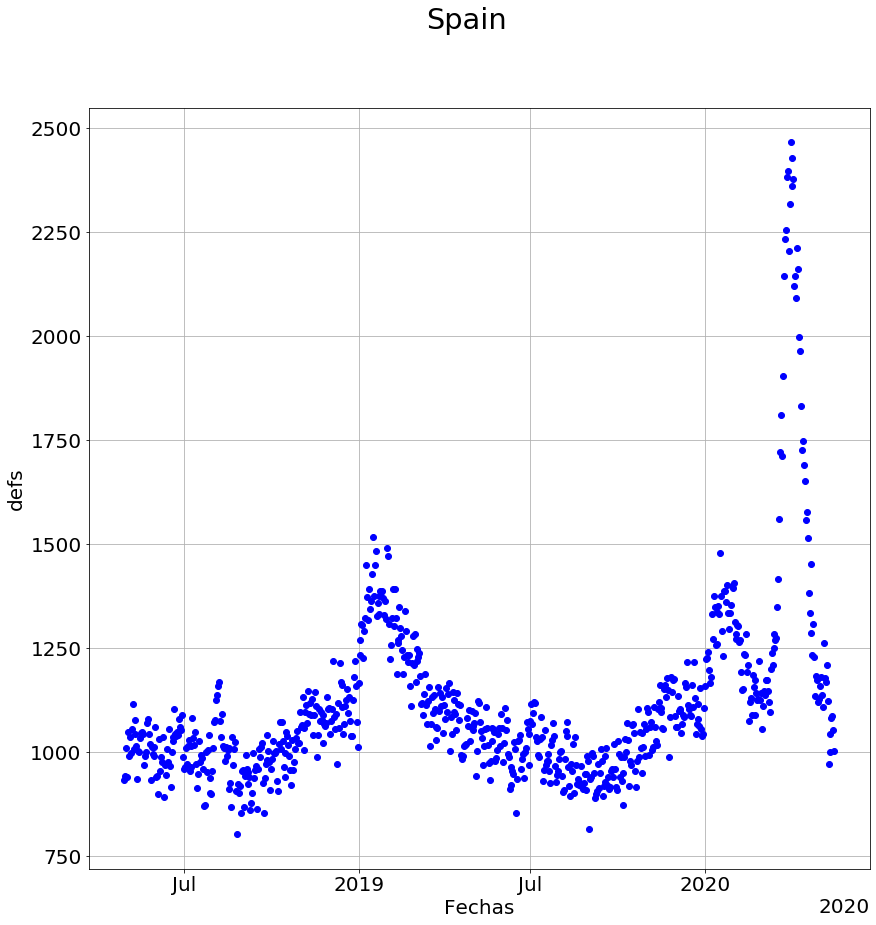

In [231]:
plot_momo(df, figsize=(14,14), ccaa='Spain')

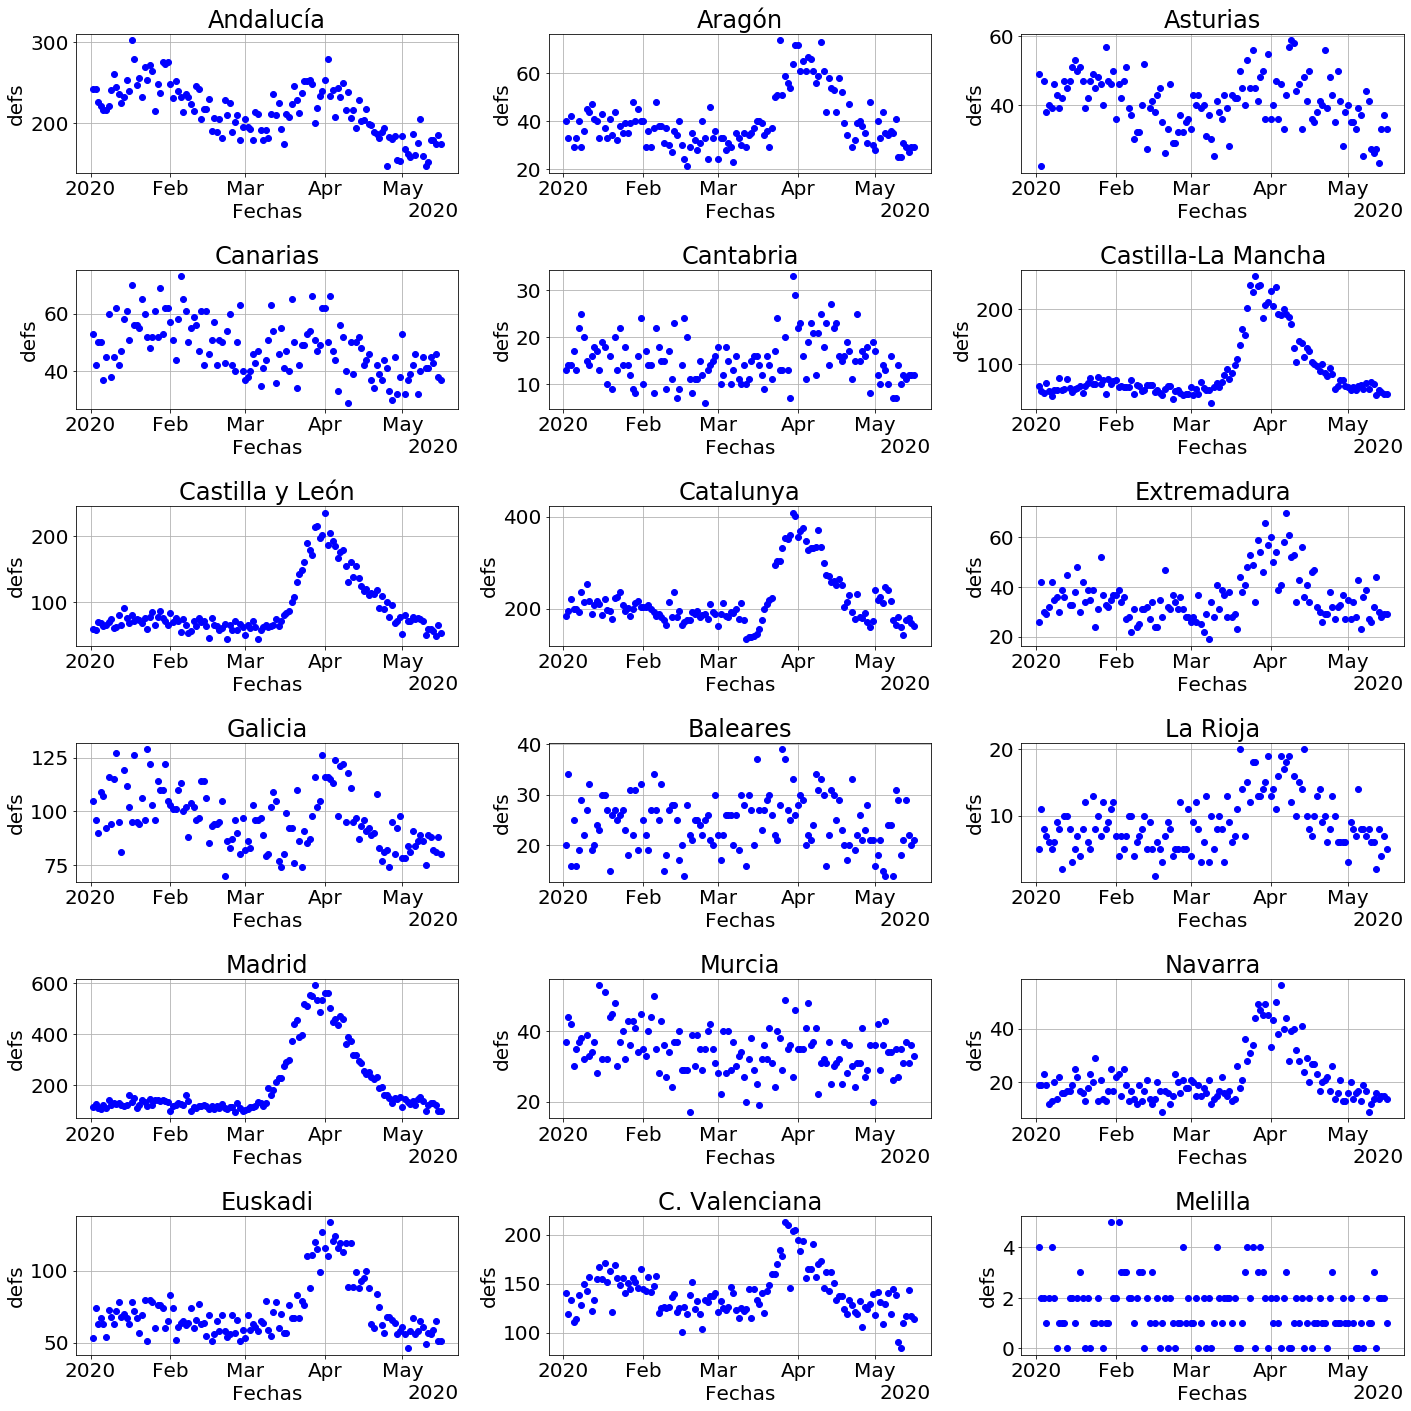

In [221]:
plot_momo_ccaa(dfcasts, ccaa_name, figsize=(20,20))